_This is the pre-recoreded version of the live demo_

## Goal

The goal of this demo project is to find the **primary school in Munich** that has
the largest proportion of **green vegetation** in its surroundings.

For this we need to:

* Load, inspect and pre-process vector data for schools and city boundaries
* Load, inspect and pre-process raster data for trees, shrubs, and grassland
* Build a joint dataset of green vegetation
* Aggregate that raster data around each school


### Preparation

* Import necessary modules
* Define paths to input files
* Set default figure size

In [1]:
from pathlib import Path
import geopandas as gp
import xarray as xr
from IPython.display import display
from matplotlib import pyplot as plt

data_dir = Path("data")

input_files = dict(
    munich=data_dir / "munich.json",
    schools=data_dir / "schools.json",
    grassland=data_dir / "grassland_25.tiff",
    small_woody_features=data_dir / "small_woody_features_27.tiff",
    tree_cover=data_dir / "tree_cover_density_25.tiff"
)

plt.rcParams['figure.figsize'] = [12, 10]

### Load and inspect the vector data

Look at GeoJSON file first, inspect the general structure.

In [2]:
schools_df = gp.read_file(input_files["schools"])
display(schools_df)

,id,@id,addr:city,addr:housenumber,addr:postcode,addr:street,amenity,building,building:levels,name,...,operator:type,loc_name,wheelchair:description,addr:housename,description,note,landuse,wikipedia,religion,geometry
0,relation/1536825,relation/1536825,München,58,81241,Bäckerstraße,school,school,4,Grundschule an der Bäckerstraße,...,None,None,None,None,None,None,None,None,None,"POLYGON ((11.46096 48.13953, 11.46060 48.13953..."
1,relation/1593473,relation/1593473,München,79,80997,Manzostraße,school,yes,None,Grundschule an der Manzostraße,...,None,None,None,None,None,None,None,None,None,"POLYGON ((11.48362 48.18395, 11.48322 48.18397..."
2,relation/2110129,relation/2110129,None,None,None,None,school,yes,2,Grundschule an der Walliser Straße,...,None,None,None,None,None,None,None,None,None,"POLYGON ((11.48242 48.09145, 11.48222 48.09112..."
3,relation/9395978,relation/9395978,München,45,81539,Weißenseestraße,school,None,None,Grundschule an der Weißenseestraße,...,None,None,None,None,None,None,None,None,None,"POLYGON ((11.58645 48.10677, 11.58625 48.10684..."
4,way/13255157,way/13255157,München,35,81379,Boschetsrieder Straße,school,school,4,Grundschule an der Boschetsrieder Straße,...,None,None,None,None,None,None,None,None,None,"POLYGON ((11.53578 48.10010, 11.53581 48.09998..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,node/4839684289,node/4839684289,None,None,None,None,school,None,None,Grundschule an der Zielstattstraße,...,None,None,None,None,None,None,None,None,None,POINT (11.51964 48.10276)
108,node/8117291546,node/8117291546,München,3,80992,Jenaer Straße,school,None,None,Grundschule an der Jenaer Straße,...,public,None,None,None,None,None,None,None,None,POINT (11.51746 48.18000)
109,node/8117330265,node/8117330265,München,71,81671,Grafinger Straße,school,None,None,Grundschule an der Grafinger Straße,...,public,None,None,None,None,None,None,None,None,POINT (11.61694 48.12550)
110,node/8538650321,node/8538650321,München,4,81675,Flurstraße,school,None,None,Grundschule an der Flurstraße,...,None,None,None,None,None,None,None,None,None,POINT (11.60533 48.13360)


Demo link to first entry in table, in OSM:
[https://www.openstreetmap.org/relation/1536825](https://www.openstreetmap.org/relation/1536825)

<AxesSubplot:>

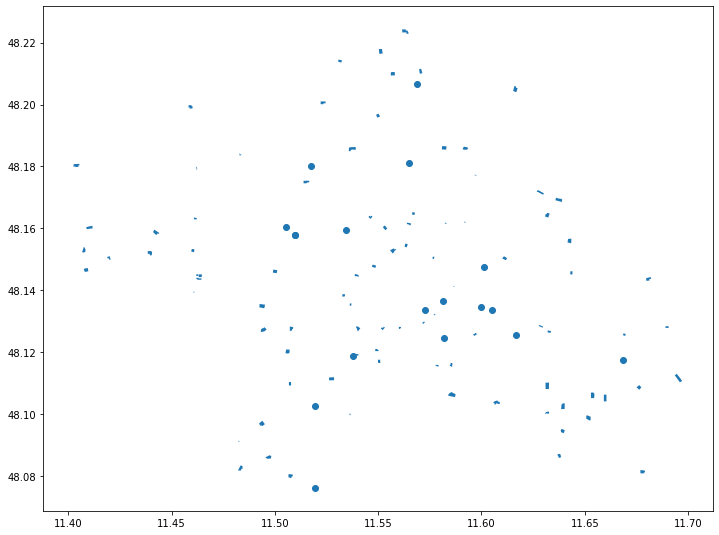

In [3]:
schools_df.plot()

In [4]:
schools_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
munich_df = gp.read_file(input_files["munich"])
display(munich_df)

,id,@id,TMC:cid_58:tabcd_1:Class,TMC:cid_58:tabcd_1:LCLversion,TMC:cid_58:tabcd_1:LocationCode,admin_level,attribution,boundary,contact:phone,contact:website,...,name:tr,name:tzl,name:uk,old_name:sl,ref:nuts:3,type,wikidata,wikipedia,@relations,geometry
0,relation/62428,relation/62428,Area,8.00,1956,6,Open Data LH München 2017,administrative,+49 89 115,https://www.muenchen.de,...,Münih,Müntsch,Мюнхен,Monakovo,DE212,boundary,Q1726,de:München,None,"MULTIPOLYGON (((11.49077 48.07395, 11.49098 48..."
1,node/1700534808,node/1700534808,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,"[ { ""role"": ""label"", ""rel"": 62428, ""reltags"": ...",POINT (11.57538 48.13711)


<AxesSubplot:>

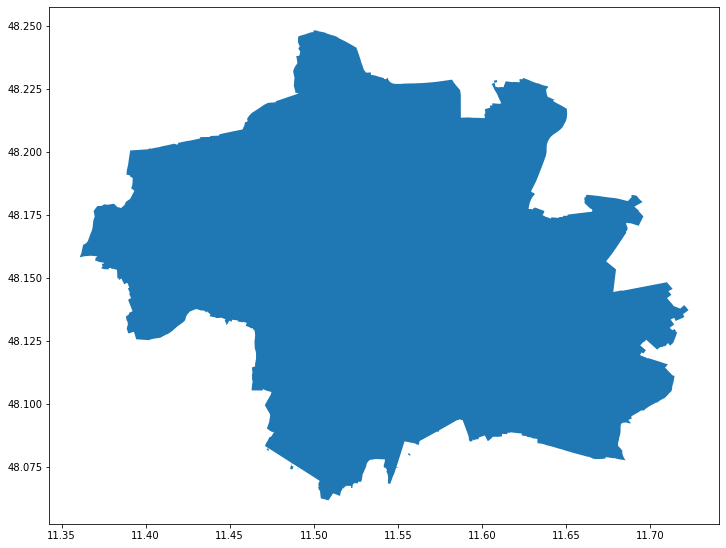

In [6]:
munich_df.plot()

### Preprocess the schools data

The dataset contains points and polygons, for some schools there are several entries.
We want to have exactly one point per school. Strategy:

* Buffer each point by 100m - for this to work, we need a metric CRS first
* Compute union of all shapes, this gives us a multipolygon
* Explode that into the distinct polygons

In [7]:
schools_df_metric = schools_df.to_crs("EPSG:25832")
display(schools_df["geometry"])
display(schools_df_metric["geometry"])

0      POLYGON ((11.46096 48.13953, 11.46060 48.13953...
1      POLYGON ((11.48362 48.18395, 11.48322 48.18397...
2      POLYGON ((11.48242 48.09145, 11.48222 48.09112...
3      POLYGON ((11.58645 48.10677, 11.58625 48.10684...
4      POLYGON ((11.53578 48.10010, 11.53581 48.09998...
                             ...                        
107                            POINT (11.51964 48.10276)
108                            POINT (11.51746 48.18000)
109                            POINT (11.61694 48.12550)
110                            POINT (11.60533 48.13360)
111                            POINT (11.59960 48.13456)
Name: geometry, Length: 112, dtype: geometry

0      POLYGON ((683074.916 5334737.128, 683048.332 5...
1      POLYGON ((684601.028 5339728.553, 684570.849 5...
2      POLYGON ((684844.065 5329445.422, 684830.269 5...
3      POLYGON ((692532.173 5331403.362, 692517.000 5...
4      POLYGON ((688785.318 5330536.079, 688787.492 5...
                             ...                        
107                       POINT (687573.928 5330792.393)
108                       POINT (687130.256 5339371.933)
109                       POINT (694730.980 5333562.147)
110                       POINT (693836.049 5334432.393)
111                       POINT (693406.361 5334524.917)
Name: geometry, Length: 112, dtype: geometry

CRS reference: [https://epsg.io/25832](https://epsg.io/25832)

This is: ETRS89 / UTM zone 32N

Background and explanations (in German!):
* https://www.ldbv.bayern.de/file/pdf/1910/UTM%20Abbildung%20und%20Koordinaten.pdf
* https://www.ldbv.bayern.de/file/pdf/10853/UTM_Abbildungsverzerrungen.pdf


<AxesSubplot:>

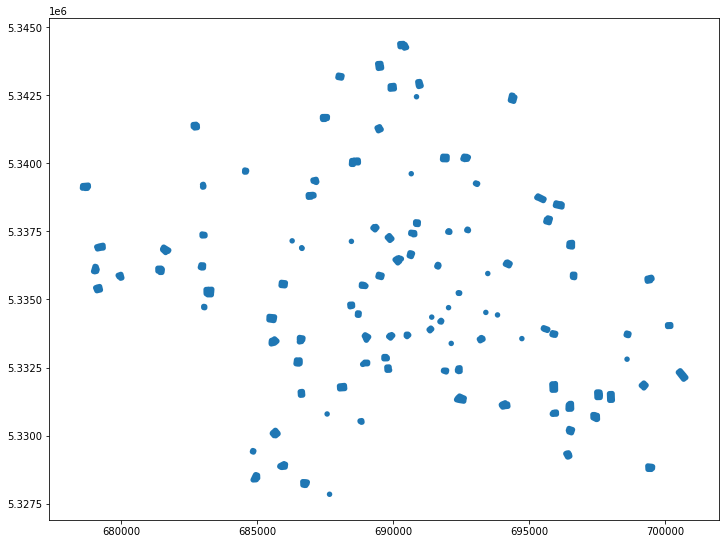

In [8]:
schools_buffered = schools_df_metric.buffer(100)
schools_buffered.plot()

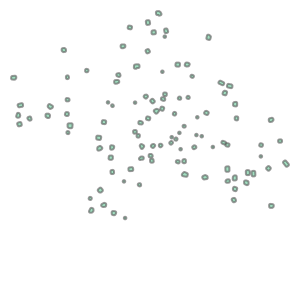

MULTIPOLYGON (((687740.2841335881 5327778.209466141, 687733.6937663704 5327770.938116439, 687726.4224166682 5327764.347749221, 687718.5401115537 5327758.501833327, 687710.1227619344 5327753.456668122, 687701.2514314883 5327749.260841306, 687692.0115559773 5327745.954760984, 687682.4921204534 5327743.570266517, 687672.7848022848 5327742.13032189, 687662.9830882518 5327741.648794557, 687653.1813742188 5327742.13032189, 687643.4740560502 5327743.570266517, 687633.9546205263 5327745.954760984, 687624.7147450153 5327749.260841306, 687615.8434145692 5327753.456668122, 687607.4260649498 5327758.501833327, 687599.5437598354 5327764.347749221, 687592.2724101332 5327770.938116439, 687585.6820429155 5327778.209466141, 687579.8361270216 5327786.091771255, 687574.7909618169 5327794.509120874, 687570.5951350007 5327803.380451321, 687567.2890546785 5327812.620326832, 687564.9045602115 5327822.139762355, 687563.4646155846 5327831.847080524, 687562.9830882518 5327841.648794557, 687563.4646155846 532785

In [9]:
schools_union = schools_buffered.unary_union
display(schools_union)
print(schools_union)

In [10]:
separated_schools = gp.GeoDataFrame(geometry=[schools_union]).explode()
display(separated_schools)

geometry
0 0    POLYGON ((687740.284 5327778.209, 687733.694 5...
  1    POLYGON ((686841.202 5328390.020, 686867.844 5...
  2    POLYGON ((685751.141 5328810.952, 685746.349 5...
  3    POLYGON ((685564.761 5330222.169, 685568.867 5...
  4    POLYGON ((684875.378 5328626.599, 684882.159 5...
...                                                  ...
  100  POLYGON ((690057.758 5342961.259, 690067.018 5...
  101  POLYGON ((689664.351 5343597.191, 689673.368 5...
  102  POLYGON ((690950.941 5342412.572, 690946.746 5...
  103  POLYGON ((690832.035 5342838.539, 690829.875 5...
  104  POLYGON ((690409.444 5344500.469, 690418.751 5...

[105 rows x 1 columns]

In [11]:
school_points = gp.GeoDataFrame(geometry=separated_schools.centroid)
display(school_points)

geometry
0 0    POINT (687662.983 5327841.649)
  1    POINT (686754.733 5328242.401)
  2    POINT (685949.975 5328888.201)
  3    POINT (685665.658 5330084.026)
  4    POINT (684945.602 5328455.130)
...                               ...
  100  POINT (689965.587 5342796.046)
  101  POINT (689502.309 5343585.598)
  102  POINT (690858.554 5342450.841)
  103  POINT (690962.129 5342919.521)
  104  POINT (690361.839 5344327.174)

[105 rows x 1 columns]

<AxesSubplot:>

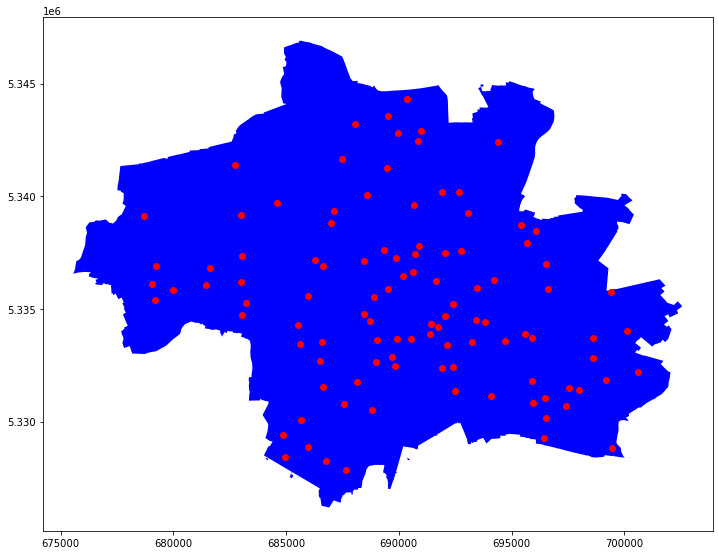

In [12]:
munich_df_metric = munich_df.to_crs("EPSG:25832")

munich_df_metric.plot(color="blue")
school_points.plot(ax=plt.gca(), color='red')

### Load and inspect the raster data

In [13]:
tree_cover = xr.open_rasterio(input_files["tree_cover"])
print(tree_cover)


<xarray.DataArray (band: 1, y: 1245, x: 1612)>
[2006940 values with dtype=uint8]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 6.148e+06 6.148e+06 6.148e+06 ... 6.117e+06 6.117e+06
  * x        (x) float64 1.265e+06 1.265e+06 1.265e+06 ... 1.305e+06 1.305e+06
Attributes:
    transform:      (25.00772334211627, 0.0, 1264675.9106559341, 0.0, -24.995...
    crs:            +init=epsg:3857
    res:            (25.00772334211627, 24.995318193712)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    DataType:       Generic


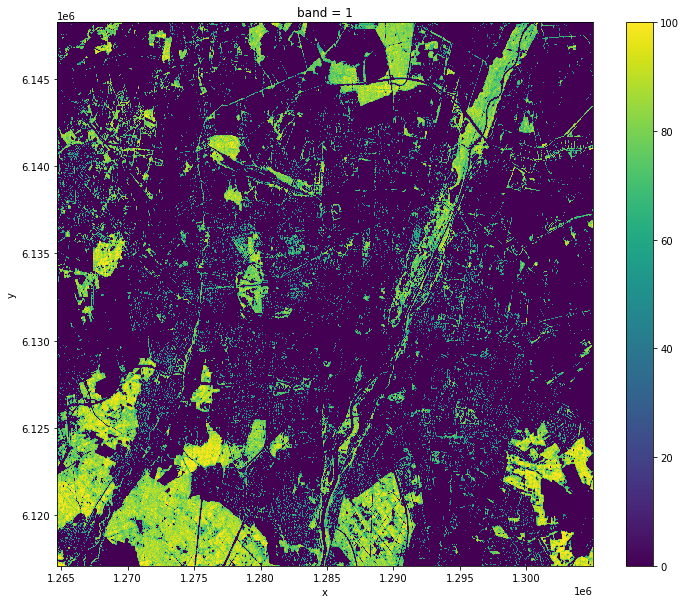

In [14]:
tree_cover.plot()

In [15]:
print(tree_cover.min(), tree_cover.max(), tree_cover.median())

<xarray.DataArray ()>
array(0, dtype=uint8) <xarray.DataArray ()>
array(100, dtype=uint8) <xarray.DataArray ()>
array(0.)


We can do min/max/mean... across one or several dimensions

In [16]:
print(tree_cover.mean(dim='x'))

<xarray.DataArray (band: 1, y: 1245)>
array([[19.06947891, 19.23325062, 19.43300248, ..., 39.63647643,
        39.90632754, 40.69168734]])
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 6.148e+06 6.148e+06 6.148e+06 ... 6.117e+06 6.117e+06


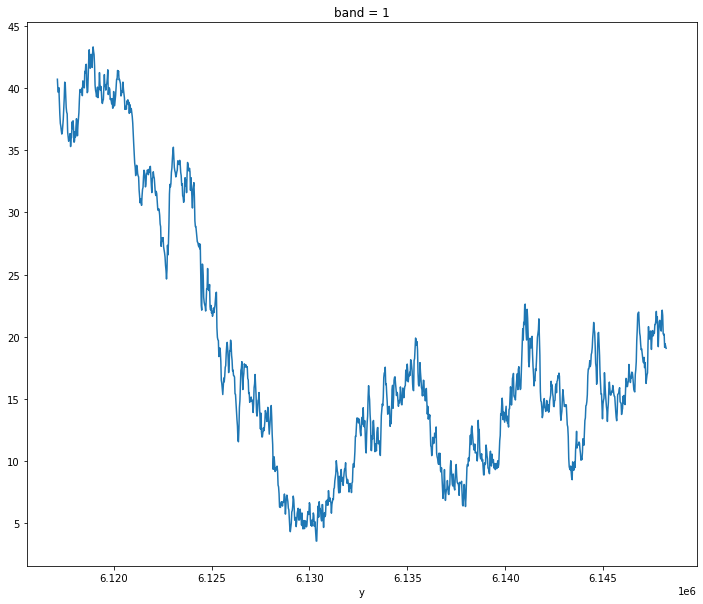

In [17]:
tree_cover.mean(dim='x').plot()

-> it's greener in the south.

Now make a binary version, threshold at 25% tree cover:

In [18]:
tree_cover_binary = tree_cover > 25

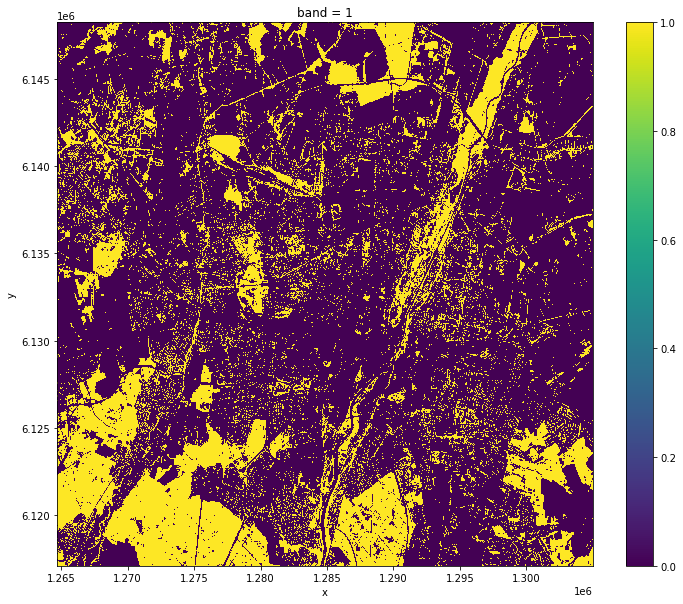

In [19]:
tree_cover_binary.plot()

Load grassland data, I already know that this is binary (but may have 255 as missing
data value, so binarize anyway).

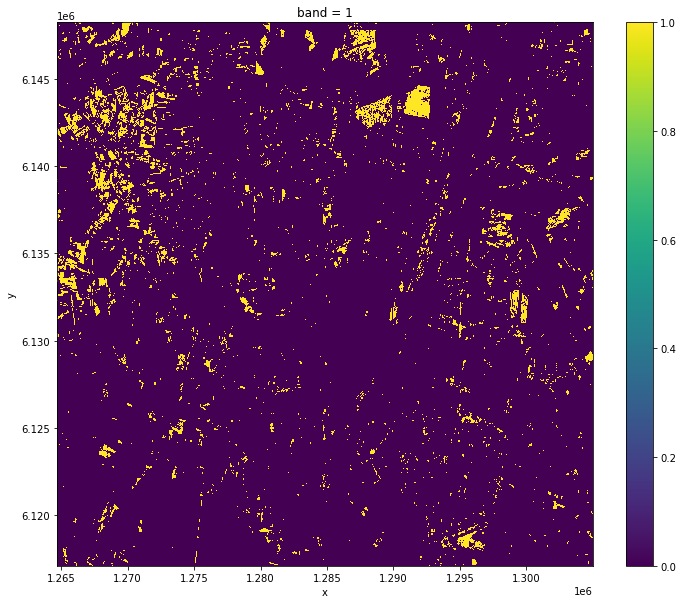

In [20]:
grassland = xr.open_rasterio(input_files["grassland"])
grassland.plot()

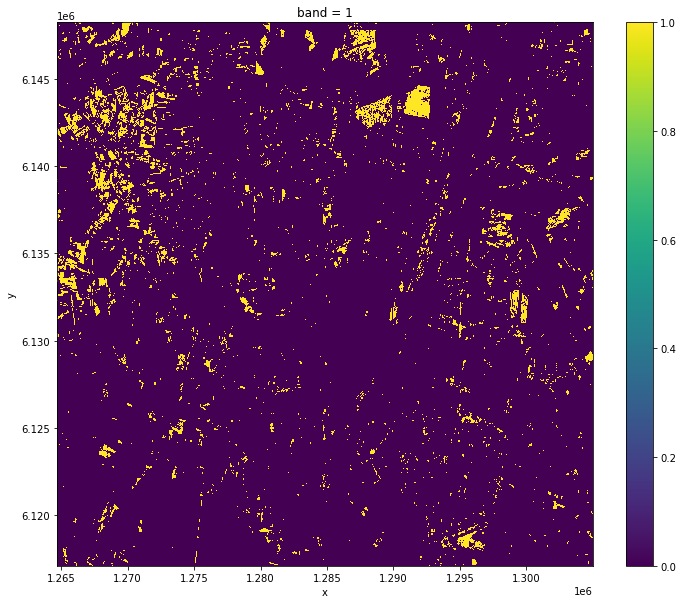

In [21]:
grassland_binary = grassland == 1
grassland_binary.plot()

Also load shrubs data

<xarray.DataArray (band: 1, y: 1153, x: 1493)>
[1721429 values with dtype=uint8]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 6.148e+06 6.148e+06 6.148e+06 ... 6.117e+06 6.117e+06
  * x        (x) float64 1.265e+06 1.265e+06 1.265e+06 ... 1.305e+06 1.305e+06
Attributes:
    transform:      (27.000971217341885, 0.0, 1264675.9106559341, 0.0, -26.98...
    crs:            +init=epsg:3857
    res:            (27.000971217341885, 26.989740807607493)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    DataType:       Generic


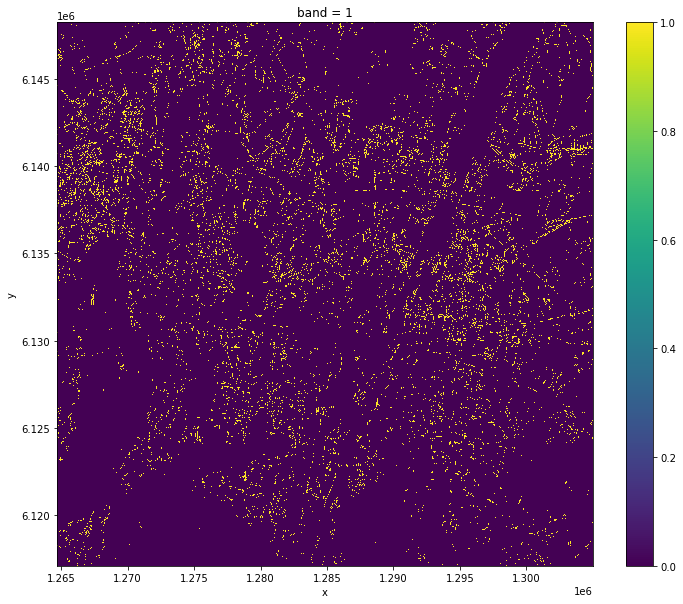

In [22]:
shrubs = xr.open_rasterio(input_files["small_woody_features"])
print(shrubs)
shrubs_binary = shrubs == 1
shrubs_binary.plot()

Stuff DataArrays into a dataset.

xarray automatically aligns the dimesions (the grid).

In [23]:
greenery = xr.Dataset(dict(trees=tree_cover_binary, grass=grassland_binary))
print(greenery)

<xarray.Dataset>
Dimensions:  (band: 1, x: 1612, y: 1245)
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 6.148e+06 6.148e+06 6.148e+06 ... 6.117e+06 6.117e+06
  * x        (x) float64 1.265e+06 1.265e+06 1.265e+06 ... 1.305e+06 1.305e+06
Data variables:
    trees    (band, y, x) bool False False False False ... True True True True
    grass    (band, y, x) bool False False False False ... False False False


In [24]:
greenery.sum()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    trees    int64 510068
    grass    int64 99233

Try to add the scrubs... this breaks the grid! More points, lots of NaNs!

In [25]:
greenery = xr.Dataset(dict(trees=tree_cover_binary, grass=grassland_binary, shrubs=shrubs_binary))
print(greenery)

<xarray.Dataset>
Dimensions:  (band: 1, x: 3105, y: 2397)
Coordinates:
  * y        (y) float64 6.117e+06 6.117e+06 6.117e+06 ... 6.148e+06 6.148e+06
  * x        (x) float64 1.265e+06 1.265e+06 1.265e+06 ... 1.305e+06 1.305e+06
  * band     (band) int64 1
Data variables:
    trees    (band, y, x) float64 1.0 nan 1.0 nan 1.0 ... 0.0 nan 0.0 nan 0.0
    grass    (band, y, x) float64 0.0 nan 0.0 nan 0.0 ... 0.0 nan 0.0 nan 0.0
    shrubs   (band, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan


I intentionally downloaded the shrubs on a different resolution, so we need to resample.

Let's try... fails at first, because xarray tries to interpolate on the 'band' dimension which
has only one point. Squeeze it out, then it works.

In [26]:
shrubs_resampled = shrubs.interp_like(tree_cover, method='nearest')

ValueError: x and y arrays must have at least 2 entries

In [27]:
shrubs_resampled = shrubs.squeeze('band').interp_like(tree_cover, method='nearest')
shrubs_binary = shrubs_resampled == 1

In [28]:
greenery = xr.Dataset(dict(trees=tree_cover_binary, grass=grassland_binary, shrubs=shrubs_binary))
print(greenery)

<xarray.Dataset>
Dimensions:  (band: 1, x: 1612, y: 1245)
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 6.148e+06 6.148e+06 6.148e+06 ... 6.117e+06 6.117e+06
  * x        (x) float64 1.265e+06 1.265e+06 1.265e+06 ... 1.305e+06 1.305e+06
Data variables:
    trees    (band, y, x) bool False False False False ... True True True True
    grass    (band, y, x) bool False False False False ... False False False
    shrubs   (y, x) bool False False False False ... False False False False


Make a joint binary DataArray of green pixels

<xarray.DataArray (band: 1, y: 1245, x: 1612)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]])
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 6.148e+06 6.148e+06 6.148e+06 ... 6.117e+06 6.117e+06
  * x        (x) float64 1.265e+06 1.265e+06 1.265e+06 ... 1.305e+06 1.305e+06


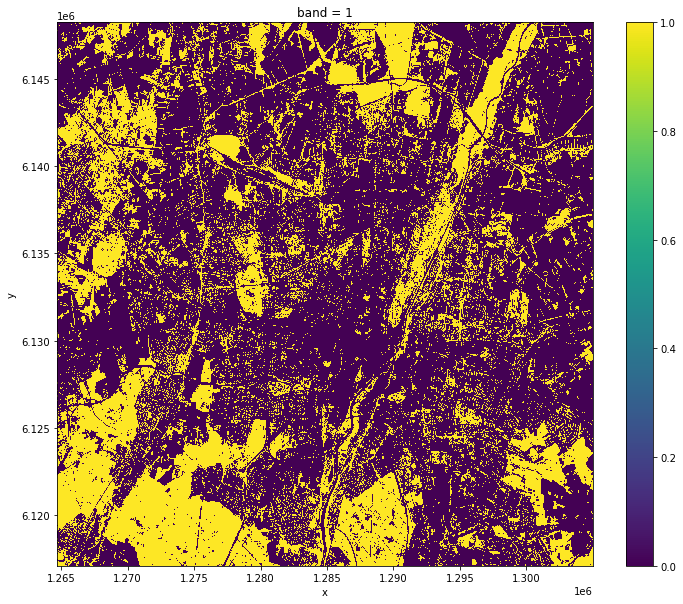

In [29]:
any_greenery = greenery["trees"] | greenery["grass"] | greenery["shrubs"]
print(any_greenery)
any_greenery.plot()

## Now determine green pixels around schools

Very simple method: select a box of +- 500 meters around each school, count green pixels.

In [30]:
school_greenery = gp.GeoDataFrame(
    dict(green_pixels=float("nan"),
         geometry=school_points["geometry"].values),
    crs="EPSG:25832")
school_greenery = school_greenery.to_crs("EPSG:3857")
print(school_greenery)

     green_pixels                         geometry
0             NaN  POINT (1282349.360 6119542.824)
1             NaN  POINT (1281012.772 6120187.426)
2             NaN  POINT (1279842.401 6121193.885)
3             NaN  POINT (1279475.689 6122999.076)
4             NaN  POINT (1278321.608 6120593.905)
..            ...                              ...
100           NaN  POINT (1286529.888 6141852.459)
101           NaN  POINT (1285875.669 6143061.103)
102           NaN  POINT (1287849.278 6141289.450)
103           NaN  POINT (1288027.790 6141987.892)
104           NaN  POINT (1287199.541 6144131.731)

[105 rows x 2 columns]


**Attention:** Note selection `(y + r, y - r)` below! `y` coordinate order is descending.

In [31]:
r = 500
for idx, point in school_greenery["geometry"].items():
    x, y = point.coords[0]
    pixel_selection = any_greenery.sel(
        dict(x=slice(x - r, x + r), y=slice(y + r, y - r))
    )
    school_greenery.loc[idx, "green_pixels"] = pixel_selection.values.sum()

    # add later, this is an example for assertion testing:
    assert pixel_selection.shape[0] == 1
    assert 40 <= pixel_selection.shape[1] <= 41
    assert 40 <= pixel_selection.shape[2] <= 41
    assert school_greenery.loc[idx, "green_pixels"] >= 0
    assert school_greenery.loc[idx, "green_pixels"] < 40 * 40

print(school_greenery)

     green_pixels                         geometry
0           354.0  POINT (1282349.360 6119542.824)
1           333.0  POINT (1281012.772 6120187.426)
2           287.0  POINT (1279842.401 6121193.885)
3           594.0  POINT (1279475.689 6122999.076)
4           300.0  POINT (1278321.608 6120593.905)
..            ...                              ...
100         194.0  POINT (1286529.888 6141852.459)
101         353.0  POINT (1285875.669 6143061.103)
102         428.0  POINT (1287849.278 6141289.450)
103         505.0  POINT (1288027.790 6141987.892)
104        1098.0  POINT (1287199.541 6144131.731)

[105 rows x 2 columns]


In [32]:
print(school_greenery["green_pixels"].describe())

count     105.000000
mean      272.733333
std       171.459362
min        19.000000
25%       147.000000
50%       256.000000
75%       375.000000
max      1098.000000
Name: green_pixels, dtype: float64


<AxesSubplot:>

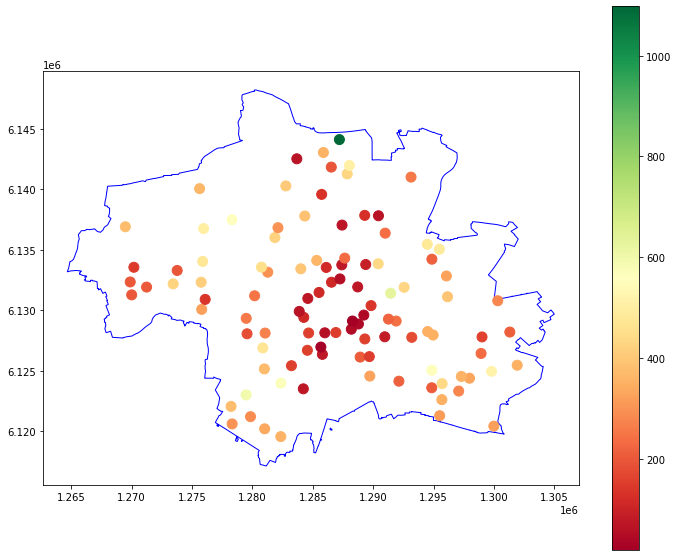

In [33]:
munich_df_metric.to_crs("EPSG:3857").iloc[[0]].plot(facecolor="white", edgecolor="blue")
school_greenery.plot(column="green_pixels", ax=plt.gca(), legend=True, cmap='RdYlGn', markersize=100)

## Example of a very simple data consistency check

In [34]:
def check_results(s):
    assert len(s) > 100
    assert len(s) < 500
    assert s.min() > 10
    assert s.max() > 40 * 40 / 2
    assert s.median() > 100
    assert s.median() < 400

check_results(school_greenery["green_pixels"])

Try what happens if you assumed that the grid was in km, setting the radius above from `500` to `0.5`,
then compute the green pixels and run the consistency check.


## Addendum: join up greenery data with original DataFrame


In [35]:
schools_with_buffered_geo = schools_df.copy()
schools_with_buffered_geo["geometry"] = schools_buffered
schools_with_buffered_geo.crs = "EPSG:25832"
joint = gp.sjoin(schools_with_buffered_geo.to_crs("EPSG:3857"), school_greenery, how="left", op="intersects").sort_values(by="green_pixels")
display(joint.head(5))
display(joint.tail(5))

,id,@id,addr:city,addr:housenumber,addr:postcode,addr:street,amenity,building,building:levels,name,...,wheelchair:description,addr:housename,description,note,landuse,wikipedia,religion,geometry,index_right,green_pixels
90,way/856493188,way/856493188,München,35,81371,Implerstraße,school,None,None,Grundschule an der Implerstraße,...,None,None,None,None,None,None,None,"POLYGON ((1285594.109 6127173.849, 1285622.775...",23.0,19.0
100,node/1576527684,node/1576527684,None,None,None,None,school,None,None,Theresia-Gerhardinger-Grundschule am Anger,...,None,None,None,None,None,None,None,"POLYGON ((1288430.397 6129106.497, 1288429.187...",81.0,19.0
41,way/108338026,way/108338026,München,27,80469,Klenzestraße,school,None,None,Grundschule am Gärtnerplatz,...,None,None,None,None,None,None,None,"POLYGON ((1288732.172 6128689.289, 1288721.169...",80.0,40.0
104,node/2654727020,node/2654727020,München,21,80539,Herrnstraße,school,None,None,Grundschule an der Herrnstraße,...,None,None,None,None,None,None,none,"POLYGON ((1289371.922 6129596.693, 1289370.710...",82.0,44.0
37,way/100318418,way/100318418,None,None,None,None,school,None,None,Grundschule an der Klenzestraße,...,None,None,None,None,None,None,None,"POLYGON ((1288021.967 6128541.555, 1288034.925...",22.0,48.0


,id,@id,addr:city,addr:housenumber,addr:postcode,addr:street,amenity,building,building:levels,name,...,wheelchair:description,addr:housename,description,note,landuse,wikipedia,religion,geometry,index_right,green_pixels
107,node/4839684289,node/4839684289,None,None,None,None,school,None,None,Grundschule an der Zielstattstraße,...,None,None,None,None,None,None,None,"POLYGON ((1282510.054 6123962.320, 1282508.854...",8.0,568.0
65,way/162202144,way/162202144,München,6,81476,Berner Straße,school,None,None,Grundschule an der Berner Straße,...,None,None,None,None,None,None,None,"POLYGON ((1279201.735 6123087.896, 1279202.601...",3.0,594.0
98,node/1405087466,node/1405087466,None,None,None,None,school,None,None,Bilinguale Grundschule Phorms,...,None,None,None,None,None,None,None,"POLYGON ((1291590.326 6131404.858, 1291589.110...",71.0,629.0
56,way/144346589,way/144346589,None,20,None,Thelottstraße,school,None,None,Grundschule mit Tagesheim an der Thelottstraße 20,...,None,None,None,None,None,None,None,"POLYGON ((1287026.335 6144396.838, 1287220.257...",104.0,1098.0
103,node/2399832597,node/2399832597,München,8,81373,Meindlstraße,school,None,None,Grundschule an der Plinganserstraße - Außenste...,...,None,None,None,None,None,None,None,"POLYGON ((1284552.120 6126630.960, 1284550.917...",NaN,NaN
